## Описание проекта

Предоставлен набор данных о заказах автомобилей. Для более точного распределения трудозатрат и рабочего времени, необходимо спрогнозировать количество заказов автомобилей на час вперед. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `dataset.csv`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error

# 1. Подготовка

#### Загрузка данных

In [2]:
data = pd.read_csv('dataset.csv', index_col = [0], parse_dates = [0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.sort_index(inplace = True)

#### Ресемплинг

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


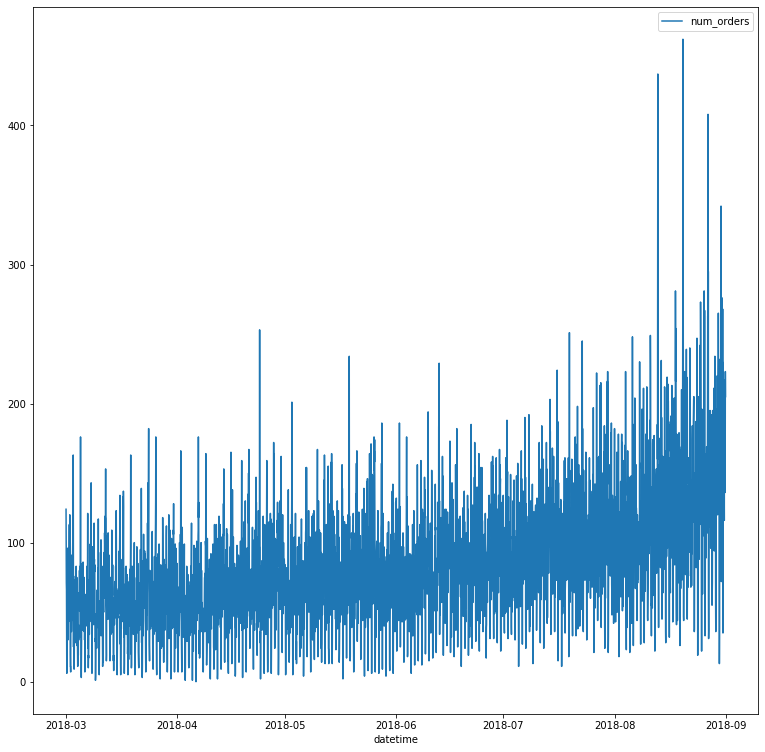

In [6]:
data = data.resample('1H').sum()
plt.pyplot.subplots(figsize = (13, 13))
sns.lineplot(data = data)

### Вывод

##### Исходные данные загружены, отсортированы и проведено ресемплирование по 1 часу. Итоговый датасет выведен на экран и изучен, невооруженным взглядом виден тренд и постоянное смещение, наличие шумовой составляющей следует изучить дополнительно.

# 2. Анализ

#### Декомпозиция

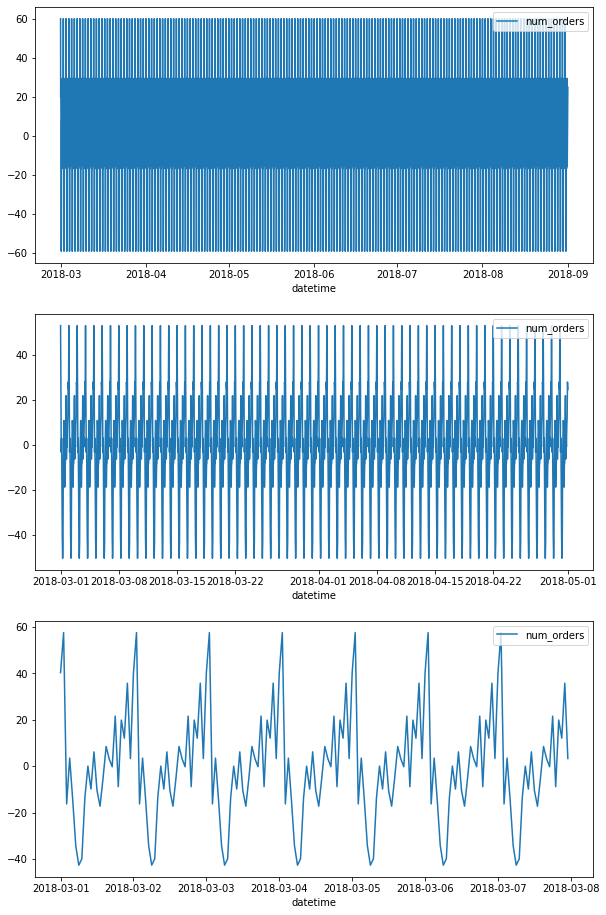

In [7]:
decomposed = seasonal_decompose(data)
seasonal = decomposed.seasonal

plt.pyplot.figure(figsize=(10, 16))
plt.pyplot.subplot(311)
sns.lineplot(data = seasonal)

decomposed = seasonal_decompose(data['2018-03':'2018-04'])
seasonal = decomposed.seasonal
plt.pyplot.subplot(312)
sns.lineplot(data = seasonal)

decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])
seasonal = decomposed.seasonal
plt.pyplot.subplot(313)
sns.lineplot(data = seasonal)

##### Проведена декомпозиция, оценена сезонность временного ряда, видно, четкое повторение с периодом в 1 день, по которому было проведено ресемплирование.

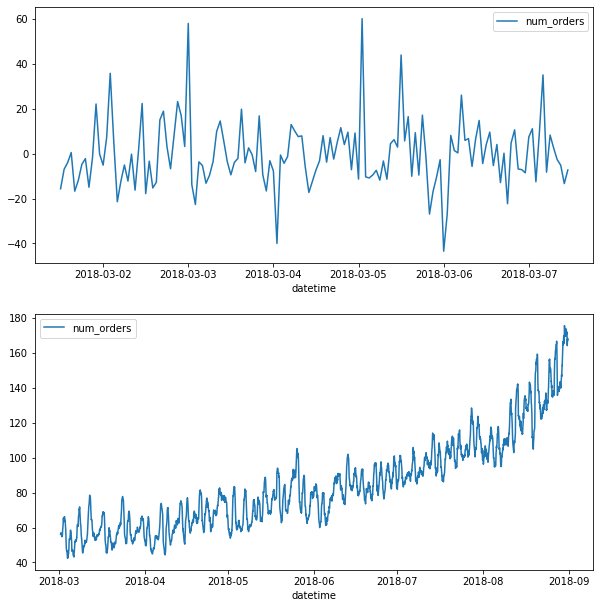

In [8]:
plt.pyplot.figure(figsize=(10, 16))

noise = decomposed.resid

plt.pyplot.subplot(311)
sns.lineplot(data = noise)

decomposed = seasonal_decompose(data)
trend = decomposed.trend

plt.pyplot.subplot(312)
sns.lineplot(data = trend)

##### Видно меняющий каждый день своё направление тренд, однако его небольшая составляющая указывает на в целом стационарность ряда, шумовая составляющая не показательна, в связи с особенностью выборки и хорошо выделяющейся сезонности.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


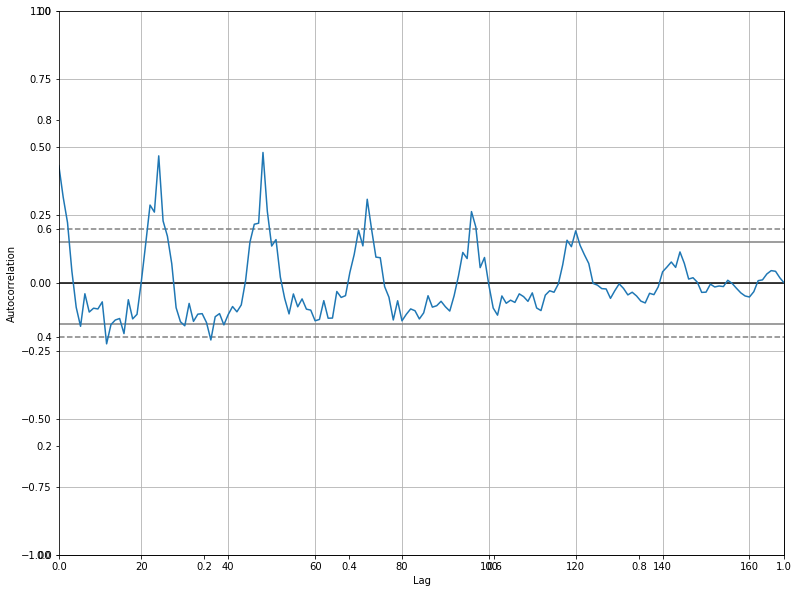

In [9]:
plt.pyplot.subplots(figsize = (13, 10))
pd.plotting.autocorrelation_plot(data['2018-03-01':'2018-03-07']['num_orders'])

##### Для общего понимания стационарности следует изучить автокорреляционную функцию, её график представлен, видны колебания в районе 1% от максимума около нуля, что в целом характеризует его стационарную составляющую, но для прогноза необходимо убрать матожидание и медленно меняющуюся составляющую, которая видна и характеризуется растущей амплитудой автокорреляции близко к нулевой задержке.

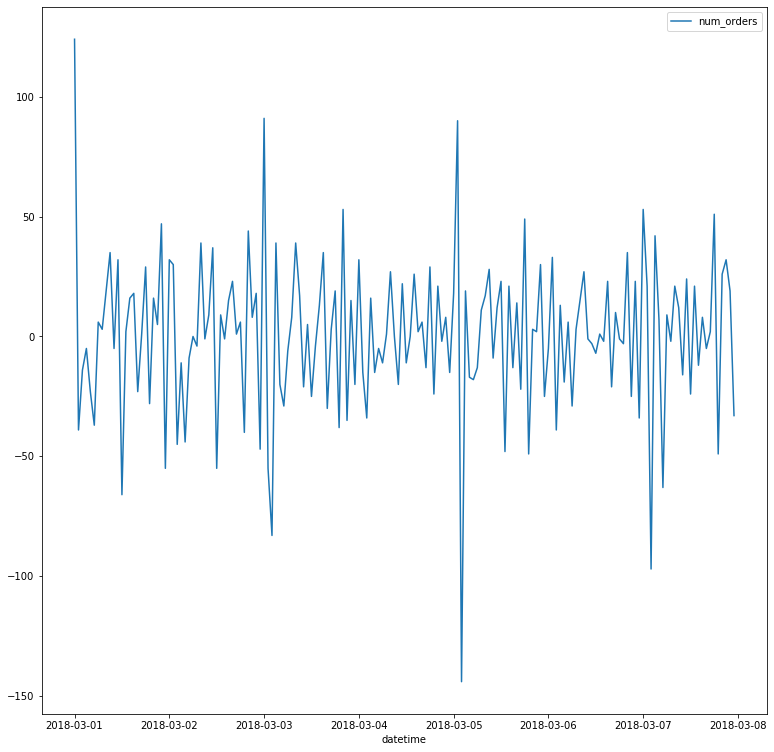

In [10]:
data = data - data.shift(fill_value=0)
plt.pyplot.subplots(figsize = (13, 13))
sns.lineplot(data = data['2018-03-01':'2018-03-07'])

#### Изучение последовательности за неделю

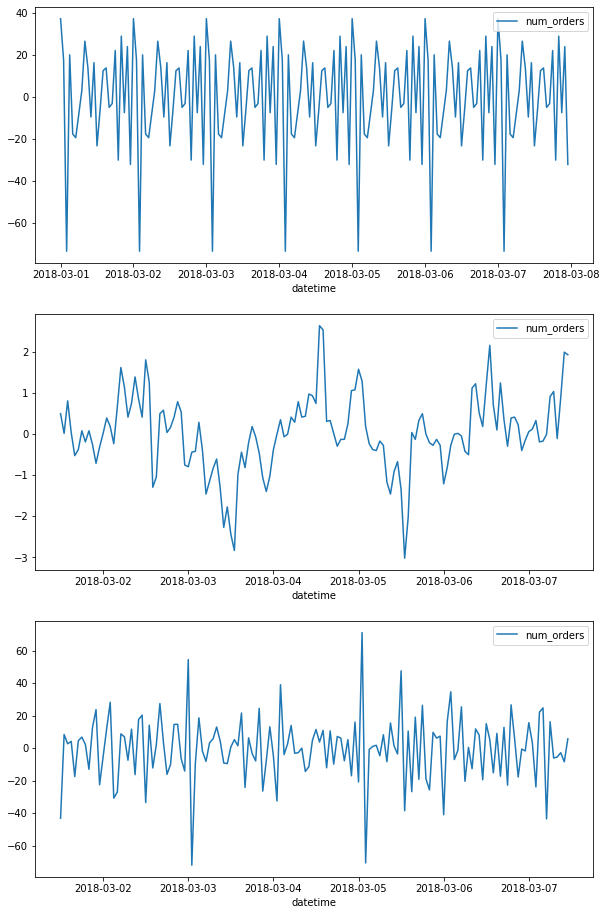

In [11]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])

plt.pyplot.figure(figsize=(10, 16))

seasonal = decomposed.seasonal
plt.pyplot.subplot(311)
sns.lineplot(data = seasonal)

trend = decomposed.trend

plt.pyplot.subplot(312)
sns.lineplot(data = trend)

noise = decomposed.resid

plt.pyplot.subplot(313)
sns.lineplot(data = noise)

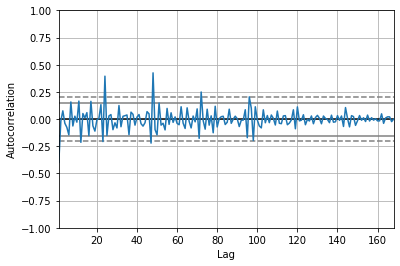

In [12]:
pd.plotting.autocorrelation_plot(data['2018-03-01':'2018-03-07']['num_orders'])

In [13]:
mean = data['num_orders'].mean()
std = data['num_orders'].std().mean()

In [14]:
print('Среднее выборки:', mean)
print('Стандартное отклонение выборки:', std)

Среднее выборки: 0.04642210144927536
Стандартное отклонение выборки: 39.063596210758


#### Добавление признаков на основе изучения данных

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df_cols = df.columns
    df_res = df.copy()
    df_res['day'] = df.index.day
    df_res['dayofweek'] = df.index.dayofweek
    df_res['hour'] = df.index.hour
        
    for lag in range(1, max_lag + 1):
        df_res['lag_{}'.format(lag)] = df[df_cols[0]].shift(lag)

    df_res['rolling_mean'] = df[df_cols[0]].shift().rolling(rolling_mean_size).mean()
    return df_res
    

In [16]:
data_work = make_features(data, 24, 2)

In [17]:
data_work.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
num_orders      4416 non-null int64
day             4416 non-null int64
dayofweek       4416 non-null int64
hour            4416 non-null int64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
lag_3           4413 non-null float64
lag_4           4412 non-null float64
lag_5           4411 non-null float64
lag_6           4410 non-null float64
lag_7           4409 non-null float64
lag_8           4408 non-null float64
lag_9           4407 non-null float64
lag_10          4406 non-null float64
lag_11          4405 non-null float64
lag_12          4404 non-null float64
lag_13          4403 non-null float64
lag_14          4402 non-null float64
lag_15          4401 non-null float64
lag_16          4400 non-null float64
lag_17          4399 non-null float64
lag_18          4398 non-null float64
lag_19          4397 

In [18]:
data_work = data.dropna()
data_work.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
num_orders      4392 non-null int64
day             4392 non-null int64
dayofweek       4392 non-null int64
hour            4392 non-null int64
lag_1           4392 non-null float64
lag_2           4392 non-null float64
lag_3           4392 non-null float64
lag_4           4392 non-null float64
lag_5           4392 non-null float64
lag_6           4392 non-null float64
lag_7           4392 non-null float64
lag_8           4392 non-null float64
lag_9           4392 non-null float64
lag_10          4392 non-null float64
lag_11          4392 non-null float64
lag_12          4392 non-null float64
lag_13          4392 non-null float64
lag_14          4392 non-null float64
lag_15          4392 non-null float64
lag_16          4392 non-null float64
lag_17          4392 non-null float64
lag_18          4392 non-null float64
lag_19          4392 

In [19]:
data_work.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,32,2,4,0,-55.0,47.0,5.0,16.0,-28.0,29.0,...,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,124.0,-4.0
2018-03-02 01:00:00,30,2,4,1,32.0,-55.0,47.0,5.0,16.0,-28.0,...,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,-11.5
2018-03-02 02:00:00,-45,2,4,2,30.0,32.0,-55.0,47.0,5.0,16.0,...,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,31.0
2018-03-02 03:00:00,-11,2,4,3,-45.0,30.0,32.0,-55.0,47.0,5.0,...,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-7.5
2018-03-02 04:00:00,-44,2,4,4,-11.0,-45.0,30.0,32.0,-55.0,47.0,...,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-28.0


In [20]:
data_features = data_work.drop('num_orders', axis = 1)
data_features = data_features
data_target = data_work['num_orders']
data_features_train, data_features_test, data_target_train, data_target_test = train_test_split(data_features, data_target, 
                                                                                               test_size = 0.1, shuffle=False,
                                                                                                random_state = 123)

In [21]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
day             4392 non-null int64
dayofweek       4392 non-null int64
hour            4392 non-null int64
lag_1           4392 non-null float64
lag_2           4392 non-null float64
lag_3           4392 non-null float64
lag_4           4392 non-null float64
lag_5           4392 non-null float64
lag_6           4392 non-null float64
lag_7           4392 non-null float64
lag_8           4392 non-null float64
lag_9           4392 non-null float64
lag_10          4392 non-null float64
lag_11          4392 non-null float64
lag_12          4392 non-null float64
lag_13          4392 non-null float64
lag_14          4392 non-null float64
lag_15          4392 non-null float64
lag_16          4392 non-null float64
lag_17          4392 non-null float64
lag_18          4392 non-null float64
lag_19          4392 non-null float64
lag_20          439

In [22]:
del data

### Вывод

##### Проведен анализ временного ряда, выделены тренды, сезонность и остатки, убраны постоянные составляющие, медленноменяющиеся составляющие временного ряда, и постоянный уход, добавлены дополнительные признаки в виде дня, дня недели, часа, задержки на час, на два часа, а также скользящего среднего. Данные разделены на обучающую и тестовую выборки.

# 3. Обучение

In [23]:
model_linear = LinearRegression()
model_linear.fit(data_features_train, data_target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

#### Случайный лес

#### Поиск параметров методом перебора по сетке

In [25]:
parameters_random_forest_grid = {
    'n_estimators' : np.arange(10, 200, 20),
    'max_depth' : np.arange(3, 16, 1),
    }
model_random_forest = RandomForestRegressor(random_state = 123)
grid_cv_random_forest = GridSearchCV(model_random_forest, parameters_random_forest_grid, scoring = 'neg_mean_squared_error', cv = cv_ts)
grid_cv_random_forest.fit(data_features_train, data_target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f639cb9e550>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='warn', 

In [26]:
grid_cv_random_forest.best_params_

{'max_depth': 13, 'n_estimators': 190}

In [27]:
grid_cv_random_forest.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=190,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [28]:
np.sqrt(-grid_cv_random_forest.best_score_)

30.802738386020835

In [29]:
model_random_forest = RandomForestRegressor(n_estimators = grid_cv_random_forest.best_params_['n_estimators'], 
                                            max_depth = grid_cv_random_forest.best_params_['max_depth'], random_state = 123)
model_random_forest.fit(data_features_train, data_target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=190,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [30]:
del grid_cv_random_forest

#### Градиентный бустинг

In [31]:
def get_result_catboost(parametr, result_fit, result_score, result_test):
    result = pd.DataFrame({'Params': parametr, 'fit_time': result_fit, 'score_time': result_score, 'test_score': result_test})
    best_result = result.loc[result['test_score'] == result['test_score'].min()]
    return result, best_result

In [32]:
cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

In [33]:
result_iter_fit_t = []
result_iter_score_t = []
result_iter_test_score = []

for iterations in range(10, 401, 20):
    model_ctboost = CatBoostRegressor(loss_function = 'RMSE', learning_rate = 0.5, depth = 5, iterations=iterations, random_state = 123)
    cvc = cross_validate(model_ctboost, data_features_train, data_target_train, cv = cv_ts, scoring = 'neg_mean_squared_error')
    result_iter_fit_t.append(np.mean(cvc['fit_time']))
    result_iter_score_t.append(np.mean(cvc['score_time']))
    result_iter_test_score.append(np.sqrt(-np.mean(cvc['test_score'])))
    cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

0:	learn: 26.9526232	total: 49ms	remaining: 441ms
1:	learn: 25.4839192	total: 50.6ms	remaining: 202ms
2:	learn: 23.8558456	total: 52.1ms	remaining: 122ms
3:	learn: 23.2111538	total: 53.6ms	remaining: 80.4ms
4:	learn: 22.2513654	total: 56ms	remaining: 56ms
5:	learn: 21.7503862	total: 69ms	remaining: 46ms
6:	learn: 21.1822592	total: 100ms	remaining: 43ms
7:	learn: 20.9331938	total: 102ms	remaining: 25.5ms
8:	learn: 20.5452661	total: 103ms	remaining: 11.5ms
9:	learn: 20.3392349	total: 105ms	remaining: 0us
0:	learn: 28.7626613	total: 3.35ms	remaining: 30.2ms
1:	learn: 26.5532038	total: 5.8ms	remaining: 23.2ms
2:	learn: 25.1983646	total: 7.95ms	remaining: 18.5ms
3:	learn: 24.4967666	total: 15.4ms	remaining: 23.1ms
4:	learn: 23.9281652	total: 57ms	remaining: 57ms
5:	learn: 23.4117677	total: 59.2ms	remaining: 39.4ms
6:	learn: 23.0358684	total: 61.2ms	remaining: 26.2ms
7:	learn: 22.7433509	total: 63.3ms	remaining: 15.8ms
8:	learn: 22.5096127	total: 70.7ms	remaining: 7.86ms
9:	learn: 22.3418392

In [34]:
del model_ctboost
del cvc

In [35]:
result_cv, best_result_iter = get_result_catboost(np.arange(10, 401, 20), result_iter_fit_t, 
                                                  result_iter_score_t, result_iter_test_score)

In [36]:
best_result_iter

,Params,fit_time,score_time,test_score
2,50,3.4735,0.00502,30.202869


In [37]:
iterations = best_result_iter['Params'].values[0]

In [38]:
cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

In [39]:
result_depth_fit_t = []
result_depth_score_t = []
result_depth_test_score = []

for depth in range(6, 13, 2):
    model_ctboost = CatBoostRegressor(loss_function = 'RMSE', learning_rate = 0.5, depth = depth, 
                                      iterations=iterations, random_state = 123)
    cvc = cross_validate(model_ctboost, data_features_train, data_target_train, cv = cv_ts, scoring = 'neg_mean_squared_error')
    result_depth_fit_t.append(np.mean(cvc['fit_time']))
    result_depth_score_t.append(np.mean(cvc['score_time']))
    result_depth_test_score.append(np.sqrt(-np.mean(cvc['test_score'])))
    cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

0:	learn: 26.3260593	total: 2.67ms	remaining: 131ms
1:	learn: 24.6076626	total: 4.77ms	remaining: 115ms
2:	learn: 22.7181095	total: 6.86ms	remaining: 107ms
3:	learn: 22.1404165	total: 8.92ms	remaining: 103ms
4:	learn: 21.2357654	total: 21.9ms	remaining: 197ms
5:	learn: 20.6790486	total: 63ms	remaining: 462ms
6:	learn: 20.3573245	total: 65.8ms	remaining: 404ms
7:	learn: 20.1090293	total: 67.8ms	remaining: 356ms
8:	learn: 19.8225360	total: 69.8ms	remaining: 318ms
9:	learn: 19.6177275	total: 77.2ms	remaining: 309ms
10:	learn: 19.3146280	total: 161ms	remaining: 572ms
11:	learn: 18.8124364	total: 164ms	remaining: 518ms
12:	learn: 18.5430953	total: 166ms	remaining: 472ms
13:	learn: 18.0814156	total: 168ms	remaining: 432ms
14:	learn: 17.7117011	total: 175ms	remaining: 409ms
15:	learn: 17.3480096	total: 260ms	remaining: 552ms
16:	learn: 17.2296409	total: 262ms	remaining: 509ms
17:	learn: 16.8139564	total: 264ms	remaining: 469ms
18:	learn: 16.5814071	total: 266ms	remaining: 434ms
19:	learn: 16.

In [40]:
del model_ctboost
del cvc

In [42]:
result_cv, best_result_depth = get_result_catboost(np.arange(6, 13, 2), result_depth_fit_t, 
                                                   result_depth_score_t, result_depth_test_score)

In [43]:
best_result_depth
depth = best_result_depth['Params'].values[0]

In [44]:
cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

In [45]:
result_l_rate_fit_t = []
result_l_rate_score_t = []
result_l_rate_test_score = []

l_rate = 0.2
for i in range(1, 25, 1):
    l_rate += 0.02
    model_ctboost = CatBoostRegressor(loss_function = 'RMSE', learning_rate = l_rate, depth = depth, 
                                      iterations=iterations, random_state = 123)
    cvc = cross_validate(model_ctboost, data_features_train, data_target_train, cv = cv_ts, scoring = 'neg_mean_squared_error')
    result_l_rate_fit_t.append(np.mean(cvc['fit_time']))
    result_l_rate_score_t.append(np.mean(cvc['score_time']))
    result_l_rate_test_score.append(np.sqrt(-np.mean(cvc['test_score'])))
    cv_ts = TimeSeriesSplit(n_splits=2).split(data_features_train)

0:	learn: 28.4694427	total: 2.38ms	remaining: 116ms
1:	learn: 27.1446068	total: 4.62ms	remaining: 111ms
2:	learn: 26.1318687	total: 6.65ms	remaining: 104ms
3:	learn: 25.2728101	total: 8.71ms	remaining: 100ms
4:	learn: 24.2286025	total: 16.2ms	remaining: 146ms
5:	learn: 23.5095601	total: 84.9ms	remaining: 623ms
6:	learn: 23.0383052	total: 87.1ms	remaining: 535ms
7:	learn: 22.7367611	total: 89.1ms	remaining: 468ms
8:	learn: 22.4557609	total: 91.2ms	remaining: 416ms
9:	learn: 22.0946318	total: 98.6ms	remaining: 394ms
10:	learn: 21.6424824	total: 182ms	remaining: 647ms
11:	learn: 21.3487737	total: 185ms	remaining: 585ms
12:	learn: 21.1925596	total: 187ms	remaining: 531ms
13:	learn: 20.7179796	total: 189ms	remaining: 486ms
14:	learn: 20.4900560	total: 197ms	remaining: 460ms
15:	learn: 20.3507149	total: 280ms	remaining: 595ms
16:	learn: 20.2113045	total: 283ms	remaining: 549ms
17:	learn: 20.1020436	total: 285ms	remaining: 506ms
18:	learn: 19.9604941	total: 287ms	remaining: 468ms
19:	learn: 1

In [46]:
del model_ctboost
del cvc

In [47]:
result_cv, best_result_lrate = get_result_catboost(np.arange(1, 25, 1), result_l_rate_fit_t, 
                                                   result_l_rate_score_t, result_l_rate_test_score)

In [48]:
best_result_lrate

,Params,fit_time,score_time,test_score
3,4,2.443198,0.008027,29.562249


In [49]:
learning_rate_ct = (0.2 + best_result_lrate['Params'].values[0] * 0.02)

In [50]:
model_ctboost = CatBoostRegressor(loss_function = 'RMSE', learning_rate = learning_rate_ct, depth = depth, 
                                  iterations=iterations, random_state = 123)
model_ctboost.fit(data_features_train, data_target_train)

0:	learn: 33.7081554	total: 3.97ms	remaining: 195ms
1:	learn: 32.3961938	total: 8.06ms	remaining: 193ms
2:	learn: 31.2469749	total: 11.4ms	remaining: 178ms
3:	learn: 30.2395023	total: 25.5ms	remaining: 294ms
4:	learn: 29.1840570	total: 28.9ms	remaining: 260ms
5:	learn: 28.3640095	total: 32.1ms	remaining: 235ms
6:	learn: 27.8757256	total: 124ms	remaining: 759ms
7:	learn: 27.6218495	total: 127ms	remaining: 666ms
8:	learn: 27.2454046	total: 130ms	remaining: 594ms
9:	learn: 26.8431529	total: 221ms	remaining: 882ms
10:	learn: 26.4602501	total: 225ms	remaining: 798ms
11:	learn: 26.2284860	total: 229ms	remaining: 724ms
12:	learn: 26.0523388	total: 320ms	remaining: 910ms
13:	learn: 25.6605685	total: 323ms	remaining: 831ms
14:	learn: 25.3973113	total: 326ms	remaining: 761ms
15:	learn: 25.1905375	total: 417ms	remaining: 886ms
16:	learn: 25.0562089	total: 423ms	remaining: 820ms
17:	learn: 24.8268194	total: 426ms	remaining: 758ms
18:	learn: 24.6194894	total: 515ms	remaining: 841ms
19:	learn: 24.46

### Вывод

##### Проведены настройка и обучения трёх алгоритмов машинного обучения: линейной регрессии, случайного леса и градиентного бустинга с архитектурой CatBoost, выбор на эту архитектуру пал ввиду её неплохого качества работы на схожих процессах, а также более быстрого обучения на базе GPU, которое понадобится для работы такси. 

# 4. Тестирование

In [51]:
rmse_test = []

In [52]:
indexes = ['Линейная регрессия', 'Случайный лес', 'Градиентный бустинг CatBoost']

In [53]:
prediction_linear_regression = model_linear.predict(data_features_test)
rmse_test.append(np.sqrt(mean_squared_error(data_target_test, prediction_linear_regression)))

In [54]:
prediction_random_forest = model_random_forest.predict(data_features_test)
rmse_test.append(np.sqrt(mean_squared_error(data_target_test, prediction_random_forest)))

In [55]:
prediction_catboost = model_ctboost.predict(data_features_test)
rmse_test.append(np.sqrt(mean_squared_error(data_target_test, prediction_catboost)))

In [56]:
project_result = pd.DataFrame(data = {'RMSE': rmse_test}, index = indexes)
project_result

,RMSE
Линейная регрессия,45.121182
Случайный лес,47.438926
Градиентный бустинг CatBoost,45.441526


In [57]:
data_target_test_tmp = data_target_test

In [58]:
plot_df = pd.DataFrame({'Истинное значение': data_target_test_tmp, 'Линейная регрессия': prediction_linear_regression, 
                        'Случайный лес': prediction_random_forest, 'Градиентный бустинг': prediction_catboost}, 
                       index = data_target_test.index)

No handles with labels found to put in legend.


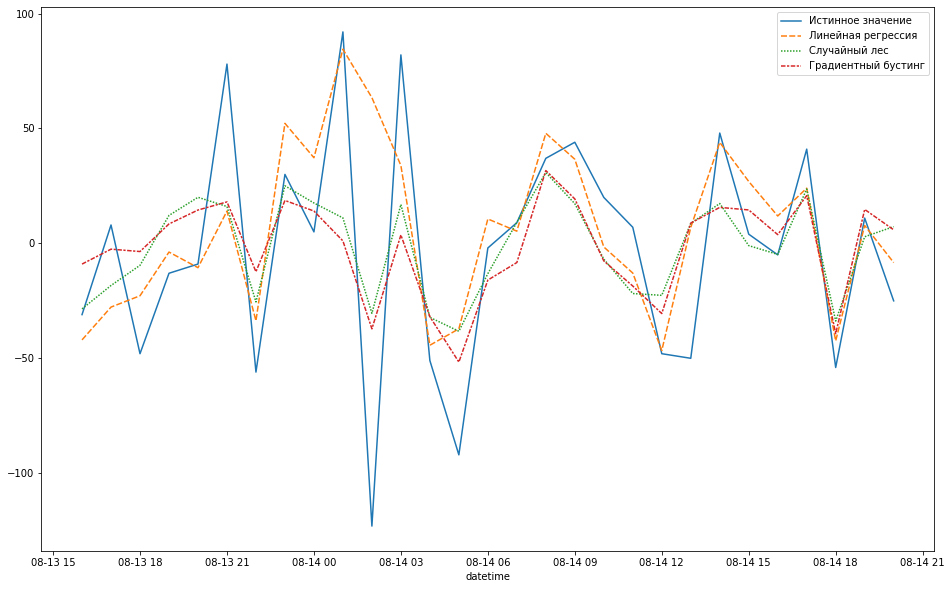

In [59]:
plt.pyplot.subplots(figsize = (16, 10))
plt.pyplot.legend()
sns.lineplot(data = plot_df['2018-08-13 14':'2018-08-14 20'])

### Вывод

##### Были построены и проанализированы прогнозы на тестовой выборке, а также построен график , по графику видно, что в верхних экстремумах линейная регрессия работает лучше, однако градиентный бустинг и случайный лес показывают схожие результаты по периодическим характеристикам, которые линейная регрессия выдерживает не так точно, однако стоит отметить, что алгоритм случайного леса был настроен с помощью перебора по сетке и следовательно его параметры близки к оптимальным. Случайный лес незначительно проигрывает двум алгоритмам. Все алгоритмы признаны подходящими, т.к. они удовлетворяют искомому значению метрики, однако с учетом того, что линейная регрессия и градиентный бустинг показали наилучший результат, предалагается выбирать между ними. При этом градиентный бустинг кажется более приоритетным вариантом в случае необходимости улучшения алгоритма, т.к. архитектура позволяет применять более тонкую настройку параметров, а линейная регрессия значительно превосходит по скорости обучения и построения прогноза.